
# Project 2: Data Preparation

**How to run:** Python 3.10+, `pip install -r requirements.txt`  
**Dataset:** `/data/project/MSA8395/mapillary_traffic_sign_dataset`  
**Outputs:** `results/figures/`


In [2]:
# ==== Phase 1 reboot: clean, reproducible ====
import os, json, random, pandas as pd, numpy as np
import cv2, matplotlib.pyplot as plt
from pathlib import Path

# ⬇️ EDIT THESE TWO if your ARC paths differ
DATA_ROOT   = "/data/project/MSA8395/mapillary_traffic_sign_dataset"  # images root
LABELS_PATH = "/data/project/MSA8395/mapillary_traffic_sign_dataset/annotations.json"  # COCO JSON or a CSV

# project-relative outputs
OUT_DIR    = Path("results")
SUBSET_DIR = OUT_DIR / "subset"
FIG_DIR    = OUT_DIR / "figures"
METRIC_DIR = OUT_DIR / "metrics"
for d in [SUBSET_DIR, FIG_DIR, METRIC_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED)

def _join(*a): 
    return os.path.abspath(os.path.join(*a))

print("OK: folders ready →", SUBSET_DIR, FIG_DIR, METRIC_DIR)


OK: folders ready → results/subset results/figures results/metrics


In [3]:
import os, re
from pathlib import Path

DATA_ROOT = "/data/project/MSA8395/mapillary_traffic_sign_dataset"
CANDIDATE_DIRS = [
    Path(DATA_ROOT) / "mtsd_v2_fully_annotated",
    Path(DATA_ROOT) / "mtsd_v2_fully_annotated" / "annotations",
    Path(DATA_ROOT) / "mtsd_v2_partially_annotated",
    Path(DATA_ROOT),
]

patterns = re.compile(r"(annot|label|bbox|instances).*?\.(csv|json)$", re.I)
found = []

for base in CANDIDATE_DIRS:
    if base.exists():
        for p in base.rglob("*"):
            if p.is_file() and patterns.search(p.name):
                found.append(p)

print("Found label candidates:")
for i, p in enumerate(sorted(found), 1):
    print(f"{i:2d}. {p}")

# Pick the first candidate by default (you can change index below if needed)
LABELS_PATH = str(found[0]) if found else None
print("\nLABELS_PATH =", LABELS_PATH)

# For images, we’ll use this:
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
print("IMAGES_DIR  =", IMAGES_DIR, "(exists:", os.path.exists(IMAGES_DIR), ")")


Found label candidates:
 1. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/SogxeShkO29Av5BVnbbOXg.json
 2. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/SogxeShkO29Av5BVnbbOXg.json
 3. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/SogxeShkO29Av5BVnbbOXg.json
 4. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/q-f1JZV9BbOxuxsT2U2WAw.json
 5. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/q-f1JZV9BbOxuxsT2U2WAw.json
 6. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/q-f1JZV9BbOxuxsT2U2WAw.json
 7. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/xfDr23piVF7bJmjQbBOxng.json
 8. /data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/xfDr23piVF7bJmjQbBOxng.json
 9. /dat

In [4]:
import os, json, math
import pandas as pd
from pathlib import Path

IMAGES_DIR = "/data/project/MSA8395/mapillary_traffic_sign_dataset/images"

# 1) Re-create the JSON list (recursive)
full_dirs = [
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations"),
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_partially_annotated/annotations"),
]
found = []
for d in full_dirs:
    if d.exists():
        found.extend(list(d.rglob("*.json")))
print(f"JSON files found: {len(found)}")

# Optional CAP for speed while testing; set to None for full run
CAP = None
json_list = found[:CAP] if CAP else found
print(f"Parsing {len(json_list)} JSON files (CAP={CAP})")

def _guess_image_path_from_json_path(json_path):
    stem = Path(json_path).stem
    # Try common extensions first
    for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]:
        p = os.path.join(IMAGES_DIR, stem + ext)
        if os.path.exists(p):
            return p
    # Try reading filename-like fields from JSON (some variants store a path)
    try:
        with open(json_path, "r") as f:
            j = json.load(f)
        for k in ["file_name","image_path","filename","imageName"]:
            fn = j.get(k)
            if fn:
                p = fn if os.path.isabs(fn) else os.path.join(IMAGES_DIR, fn)
                if os.path.exists(p):
                    return p
    except Exception:
        pass
    return None

def _bbox_from_polygon(poly):
    # poly can be dict with 'x'/'y' arrays or list of [x,y] points
    try:
        if isinstance(poly, dict) and "x" in poly and "y" in poly:
            xs, ys = poly["x"], poly["y"]
        elif isinstance(poly, list) and len(poly) > 0 and isinstance(poly[0], (list, tuple)) and len(poly[0]) >= 2:
            xs = [p[0] for p in poly]
            ys = [p[1] for p in poly]
        else:
            return None
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        w = max(0.0, xmax - xmin)
        h = max(0.0, ymax - ymin)
        return (float(xmin), float(ymin), float(w), float(h))
    except Exception:
        return None

def _denorm_if_needed(x, y, w, h, meta):
    # Detect normalization and denormalize if possible
    W = meta.get("width") or meta.get("image_width") or meta.get("imgWidth")
    H = meta.get("height") or meta.get("image_height") or meta.get("imgHeight")
    def _is_norm(v):
        try:
            v = float(v); return 0.0 <= v <= 1.0
        except:
            return False
    if all(_is_norm(v) for v in [x,y,w,h]) and W and H:
        return x*W, y*H, w*W, h*H
    return x, y, w, h

def _extract_rows_from_json(j, image_path_abs):
    rows = []
    objs = j.get("objects", [])
    meta = {
        "width": j.get("width") or j.get("image_width") or j.get("imgWidth"),
        "height": j.get("height") or j.get("image_height") or j.get("imgHeight")
    }
    for obj in objs:
        label = obj.get("label") or obj.get("class") or obj.get("category") or "unknown"
        bbox  = obj.get("bbox", {})
        got_box = None

        # Priority: explicit x,y,w,h
        if isinstance(bbox, dict) and {"x","y","w","h"}.issubset(bbox.keys()):
            x,y,w,h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
            x,y,w,h = map(float, [x,y,w,h])
            got_box = (x,y,w,h)
        # Or xmin,ymin,xmax,ymax
        elif isinstance(bbox, dict) and {"xmin","ymin","xmax","ymax"}.issubset(bbox.keys()):
            xmin,ymin,xmax,ymax = [float(bbox["xmin"]), float(bbox["ymin"]), float(bbox["xmax"]), float(bbox["ymax"])]
            got_box = (xmin, ymin, max(0.0, xmax-xmin), max(0.0, ymax-ymin))
        # Or polygon (common in MTSD)
        elif "polygon" in obj:
            bb = _bbox_from_polygon(obj["polygon"])
            if bb:
                got_box = bb
        # Some variants use "points" or "vertices"
        elif "points" in obj:
            bb = _bbox_from_polygon(obj["points"])
            if bb:
                got_box = bb

        if not got_box:
            continue

        x,y,w,h = _denorm_if_needed(*got_box, meta)
        if w <= 1 or h <= 1:
            continue

        rows.append({
            "image_path_abs": os.path.abspath(image_path_abs),
            "x": float(x), "y": float(y), "w": float(w), "h": float(h),
            "class_name": str(label)
        })
    return rows

all_rows = []
skipped_noimg = 0
parsed = 0
with_img = 0
with_boxes = 0

for i, jp in enumerate(json_list, 1):
    img_path = _guess_image_path_from_json_path(jp)
    if not img_path:
        skipped_noimg += 1
        continue
    with_img += 1
    try:
        with open(jp, "r") as f:
            j = json.load(f)
        rows = _extract_rows_from_json(j, img_path)
        if rows:
            with_boxes += 1
            all_rows.extend(rows)
    except Exception:
        pass
    parsed += 1
    if i % 5000 == 0:
        print(f"... {i}/{len(json_list)} JSONs | parsed={parsed} | with_img={with_img} | with_boxes={with_boxes} | rows={len(all_rows)}")

df_master = pd.DataFrame(all_rows)
df_master = df_master[
    (df_master["w"] > 1) & (df_master["h"] > 1) & (df_master["image_path_abs"].apply(os.path.exists))
].copy()

MASTER_CSV = Path("results/subset/annotations_master.csv")
MASTER_CSV.parent.mkdir(parents=True, exist_ok=True)
df_master.to_csv(MASTER_CSV, index=False)

print("\nMaster annotations saved:", str(MASTER_CSV))
print("Rows:", len(df_master), "| Classes:", df_master["class_name"].nunique(),
      "| skipped_noimg:", skipped_noimg, "| with_img:", with_img, "| JSONs_with_boxes:", with_boxes)


JSON files found: 95286
Parsing 95286 JSON files (CAP=None)
... 15000/95286 JSONs | parsed=935 | with_img=935 | with_boxes=930 | rows=4633
... 20000/95286 JSONs | parsed=5270 | with_img=5270 | with_boxes=5248 | rows=25856
... 25000/95286 JSONs | parsed=9656 | with_img=9656 | with_boxes=9626 | rows=47715
... 60000/95286 JSONs | parsed=16942 | with_img=16942 | with_boxes=16905 | rows=68989
... 65000/95286 JSONs | parsed=21942 | with_img=21942 | with_boxes=21905 | rows=78032

Master annotations saved: results/subset/annotations_master.csv
Rows: 84467 | Classes: 401 | skipped_noimg: 69746 | with_img: 25540 | JSONs_with_boxes: 25503


In [5]:
from pathlib import Path

full_dirs = [
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations"),
    Path("/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_partially_annotated/annotations"),
]

found = []
for d in full_dirs:
    if d.exists():
        found.extend(list(d.rglob("*.json")))  # recursive

print("Total JSONs found:", len(found))
print("Example:", found[:5])


Total JSONs found: 95286
Example: [PosixPath('/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/--48MAqc82-bZdgGpaiexA.json'), PosixPath('/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/--7fWq6WjZM8L1eUSuvOEA.json'), PosixPath('/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/--A4b2SOWVi4KL_ryAAtTg.json'), PosixPath('/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/--FValmNpFJ8yo8X7uWODA.json'), PosixPath('/data/project/MSA8395/mapillary_traffic_sign_dataset/mtsd_v2_fully_annotated/annotations/--L1OMr84-e5nOLbNH5sBA.json')]


In [6]:
import pandas as pd, numpy as np, random, os
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED)

MASTER_CSV = "results/subset/annotations_master.csv"
df_master = pd.read_csv(MASTER_CSV)

# pick Top-5 most frequent classes
freq = df_master["class_name"].value_counts()
top5 = freq.head(5).index.tolist()
print("Top-5 classes:", top5)

df_top = df_master[df_master["class_name"].isin(top5)].copy()

# choose ≈100 images per class (by unique image)
def pick_images_for_class(df_c, n_images=100, seed=SEED):
    imgs = df_c["image_path_abs"].drop_duplicates()
    chosen = imgs.sample(n=min(n_images, len(imgs)), random_state=seed)
    return df_c[df_c["image_path_abs"].isin(chosen)]

parts = [pick_images_for_class(df_top[df_top["class_name"]==c], 100) for c in top5]
df_subset = pd.concat(parts, ignore_index=True)

# 70/15/15 split by IMAGE
def split_by_image(df_sub, train=0.70, val=0.15, test=0.15, seed=SEED):
    images = df_sub["image_path_abs"].drop_duplicates().sample(frac=1.0, random_state=seed)
    n = len(images); n_train = int(n*train); n_val = int(n*val)
    S_train = set(images.iloc[:n_train])
    S_val   = set(images.iloc[n_train:n_train+n_val])
    S_test  = set(images.iloc[n_train+n_val:])
    def lab(p):
        if p in S_train: return "train"
        if p in S_val:   return "val"
        return "test"
    out = df_sub.copy()
    out["split"] = out["image_path_abs"].map(lab)
    return out

df_subset = split_by_image(df_subset)

# normalize for later phases
df_subset["image_path"] = df_subset["image_path_abs"]
df_subset["label"]      = df_subset["class_name"]

cols_out = ["image_path","x","y","w","h","label","split","image_path_abs","class_name"]
df_subset = df_subset[cols_out].copy()

SUBSET_CSV = Path("results/subset/subset_split.csv")
SUBSET_CSV.parent.mkdir(parents=True, exist_ok=True)
df_subset.to_csv(SUBSET_CSV, index=False)

print("Subset split saved:", str(SUBSET_CSV))
print(df_subset["split"].value_counts())


Top-5 classes: ['other-sign', 'regulatory--yield--g1', 'information--pedestrians-crossing--g1', 'regulatory--no-entry--g1', 'regulatory--stop--g1']
Subset split saved: results/subset/subset_split.csv
split
train    575
test     120
val      115
Name: count, dtype: int64


In [7]:
# Rebuild master with a larger CAP
CAP = 50000   # or None for full dataset
json_list = found[:CAP] if CAP else found
print(f"Parsing {len(json_list)} JSONs (CAP={CAP})")

# ... (reuse the same Block 2d code you ran earlier) ...
# After it finishes, confirm:
import pandas as pd
df_master = pd.read_csv("results/subset/annotations_master.csv")
print("Rows:", len(df_master), "| Classes:", df_master["class_name"].nunique())


Parsing 50000 JSONs (CAP=50000)
Rows: 84467 | Classes: 401


In [8]:
import pandas as pd, numpy as np, random

SEED = 42
random.seed(SEED); np.random.seed(SEED)

MASTER_CSV = "results/subset/annotations_master.csv"
df_master = pd.read_csv(MASTER_CSV)

# 1) Top-5 (or all if fewer)
class_counts = df_master["class_name"].value_counts()
topN = min(5, class_counts.shape[0])
top_classes = class_counts.head(topN).index.tolist()
print("Using classes:", top_classes)
df_top = df_master[df_master["class_name"].isin(top_classes)].copy()

# 2) Choose up to 100 IMAGES per class (or fewer if not available)
def pick_images_for_class(df_c, n_images=100, seed=SEED):
    imgs = df_c["image_path_abs"].drop_duplicates()
    chosen = imgs.sample(n=min(n_images, len(imgs)), random_state=seed)
    return df_c[df_c["image_path_abs"].isin(chosen)]

parts = [pick_images_for_class(df_top[df_top["class_name"]==c], 100) for c in top_classes]
df_subset = pd.concat(parts, ignore_index=True)

# 3) Per-class split by IMAGE with minimum guarantees
def per_class_split(df_c, train=0.70, val=0.15, test=0.15, seed=SEED):
    imgs = df_c["image_path_abs"].drop_duplicates().sample(frac=1.0, random_state=seed).tolist()
    n = len(imgs)
    # fallback for very small classes
    if n >= 10:
        n_train = int(n*train); n_val = int(n*val)
    elif n >= 6:
        # slightly different to ensure val exists
        n_train = max(1, int(round(n*0.7)))
        n_val   = max(1, int(round(n*0.15)))
    else:
        # tiny class: 80/10/10 with floors
        n_train = max(1, int(round(n*0.8)))
        n_val   = 1 if n - n_train >= 2 else 0  # try to keep at least 1 for val if possible

    # ensure we don’t exceed
    n_train = min(n_train, n)
    n_val   = min(n_val, max(0, n - n_train))
    n_test  = max(0, n - n_train - n_val)

    S_train = set(imgs[:n_train])
    S_val   = set(imgs[n_train:n_train+n_val])
    S_test  = set(imgs[n_train+n_val:])

    out = df_c.copy()
    def tag(p):
        if p in S_train: return "train"
        if p in S_val:   return "val"
        return "test"
    out["split"] = out["image_path_abs"].map(tag)
    return out

per_class_parts = []
for c in top_classes:
    per_class_parts.append(per_class_split(df_subset[df_subset["class_name"]==c]))
df_subset_new = pd.concat(per_class_parts, ignore_index=True)

# 4) Normalize columns and save
df_subset_new["image_path"] = df_subset_new["image_path_abs"]
df_subset_new["label"]      = df_subset_new["class_name"]
cols_out = ["image_path","x","y","w","h","label","split","image_path_abs","class_name"]
df_subset_new = df_subset_new[cols_out].copy()

SUBSET_CSV = "results/subset/subset_split.csv"
Path("results/subset").mkdir(parents=True, exist_ok=True)
df_subset_new.to_csv(SUBSET_CSV, index=False)

print("Subset split saved:", SUBSET_CSV)
print("Overall split counts:\n", df_subset_new.drop_duplicates(subset=["image_path","split"])["split"].value_counts())
print("\nPer-class image counts per split:")
for c in top_classes:
    tmp = df_subset_new[df_subset_new["class_name"]==c].drop_duplicates(subset=["image_path","split"])
    print(f"- {c}:",
          tmp["split"].value_counts().to_dict())


Using classes: ['other-sign', 'regulatory--yield--g1', 'information--pedestrians-crossing--g1', 'regulatory--no-entry--g1', 'regulatory--stop--g1']
Subset split saved: results/subset/subset_split.csv
Overall split counts:
 split
train    346
val       75
test      74
Name: count, dtype: int64

Per-class image counts per split:
- other-sign: {'train': 70, 'val': 15, 'test': 15}
- regulatory--yield--g1: {'train': 70, 'val': 15, 'test': 15}
- information--pedestrians-crossing--g1: {'train': 70, 'val': 15, 'test': 15}
- regulatory--no-entry--g1: {'train': 70, 'val': 15, 'test': 15}
- regulatory--stop--g1: {'train': 70, 'val': 15, 'test': 15}


images by split: 346 75 74


/tmp/ipykernel_3305845/3332731628.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


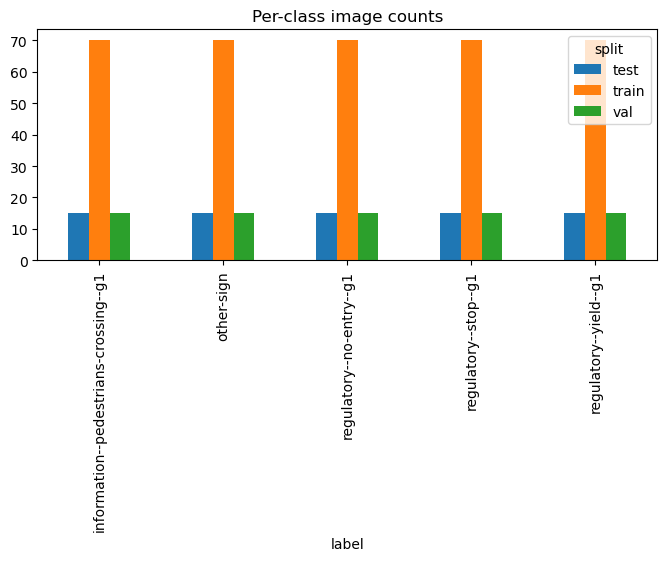

In [9]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

SUBSET_CSV = "results/subset/subset_split.csv"
df = pd.read_csv(SUBSET_CSV)
assert {"image_path","x","y","w","h","label","split"}.issubset(df.columns), df.columns

train_df = df[df["split"]=="train"].copy()
val_df   = df[df["split"]=="val"].copy()
test_df  = df[df["split"]=="test"].copy()

print("images by split:",
      train_df["image_path"].nunique(),
      val_df["image_path"].nunique(),
      test_df["image_path"].nunique())

# class balance (by image)
fig = plt.figure(figsize=(8,3))
df.drop_duplicates(["image_path","label"]).groupby(["split","label"]).size().unstack(0).plot(kind="bar", ax=plt.gca())
plt.title("Per-class image counts")
plt.tight_layout(); plt.show()


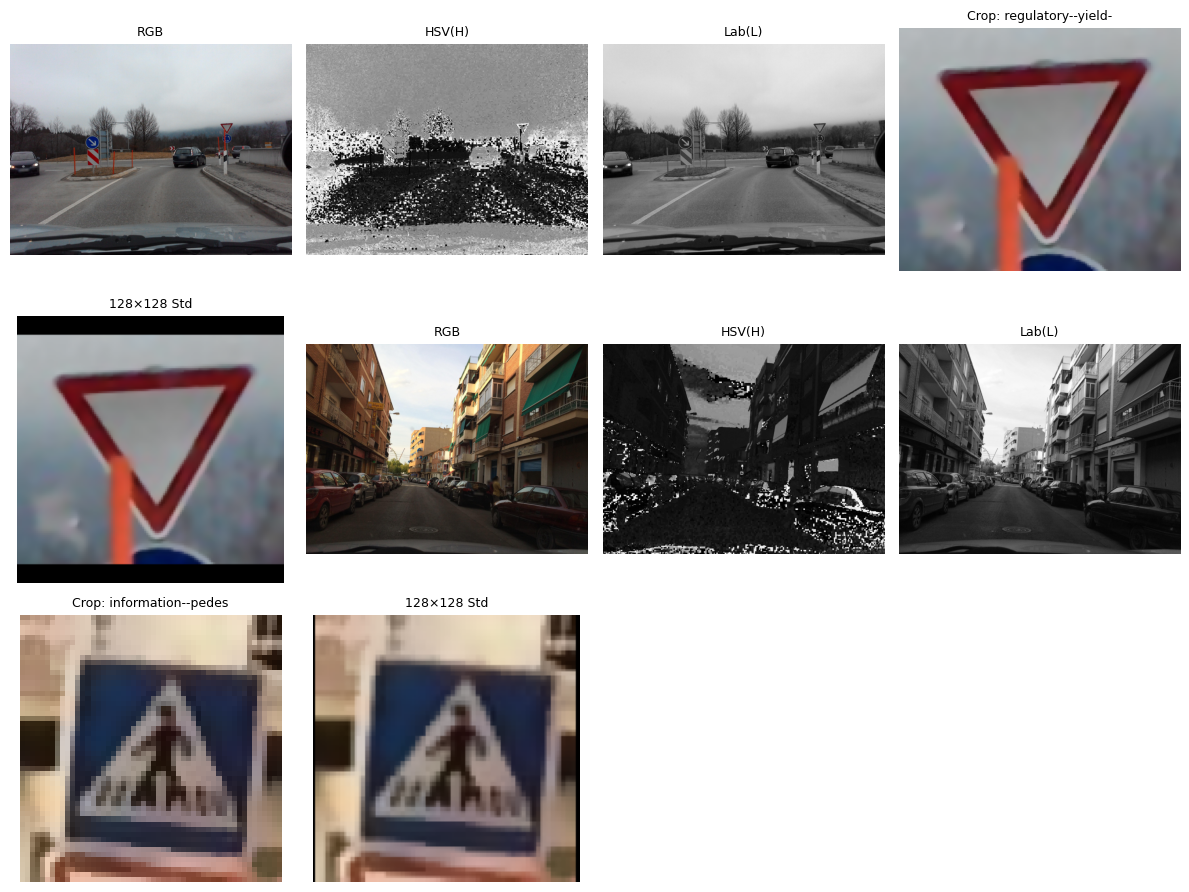

Saved: results/figures/preprocessing_examples.png


In [10]:
import cv2, numpy as np, matplotlib.pyplot as plt, os

FIG_DIR = Path("results/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

def to_rgb(img): return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def enhance_image(bgr):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)
    L,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    L2 = clahe.apply(L)
    lab2 = cv2.merge([L2,a,b])
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_Lab2BGR)
    return cv2.bilateralFilter(bgr2, d=7, sigmaColor=60, sigmaSpace=60)

def extract_and_standardize(bgr, rows_df, pad_ratio=0.15, out_size=128, enhance=True):
    if enhance: bgr = enhance_image(bgr)
    H,W = bgr.shape[:2]; out=[]
    for _, r in rows_df.iterrows():
        x,y,w,h = map(int, [r["x"],r["y"],r["w"],r["h"]])
        px,py = int(w*pad_ratio), int(h*pad_ratio)
        x1,y1 = max(0,x-px), max(0,y-py)
        x2,y2 = min(W,x+w+px), min(H,y+h+py)
        crop = bgr[y1:y2, x1:x2]
        if crop.size == 0: continue
        ch,cw = crop.shape[:2]
        scale = out_size / max(ch,cw)
        resized = cv2.resize(crop, (int(cw*scale), int(ch*scale)), interpolation=cv2.INTER_AREA)
        pad_t = (out_size-resized.shape[0])//2; pad_b = out_size-resized.shape[0]-pad_t
        pad_l = (out_size-resized.shape[1])//2; pad_r = out_size-resized.shape[1]-pad_l
        standardized = cv2.copyMakeBorder(resized, pad_t,pad_b,pad_l,pad_r, cv2.BORDER_CONSTANT, value=(0,0,0))
        out.append((crop, standardized, r["label"]))
    return out

def demo_preprocessing(df_ann, n_images=2, enhance=True, save_path=FIG_DIR/"preprocessing_examples.png"):
    import math
    imgs = df_ann["image_path"].drop_duplicates().sample(n=min(n_images, df_ann["image_path"].nunique()), random_state=42)
    tiles = []
    for p in imgs:
        bgr = cv2.imread(p); 
        if bgr is None: continue
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)
        rows = df_ann[df_ann["image_path"]==p].head(4) # up to 4 signs shown
        crops = extract_and_standardize(bgr, rows, enhance=enhance)
        tiles.extend([
            ("RGB", to_rgb(bgr)),
            ("HSV(H)", hsv[:,:,0]),
            ("Lab(L)", lab[:,:,0]),
        ])
        for crop, std, lab_ in crops:
            tiles.append((f"Crop: {str(lab_)[:18]}", to_rgb(crop)))
            tiles.append(("128×128 Std", to_rgb(std)))
    # render a grid
    cols = 4
    rows = int(np.ceil(len(tiles)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.ravel()
    for ax, (title, im) in zip(axes, tiles):
        if im.ndim==2:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)
        ax.set_title(title, fontsize=9); ax.axis("off")
    for k in range(len(tiles), len(axes)): axes[k].axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=160); plt.show()
    print("Saved:", save_path)

demo_preprocessing(train_df, n_images=2, enhance=True)


In [11]:
import cv2, numpy as np

def _color_masks_hsv(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    # red has two ranges in HSV
    red1 = cv2.inRange(hsv, (0,100,80), (10,255,255))
    red2 = cv2.inRange(hsv, (170,100,80), (180,255,255))
    blue = cv2.inRange(hsv, (100,120,70), (130,255,255))
    yellow = cv2.inRange(hsv, (15,140,90), (35,255,255))
    red = cv2.bitwise_or(red1, red2)
    return red, blue, yellow

def _morph(mask, open_k=3, close_k=5):
    k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_k,open_k))
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_k,close_k))
    return cv2.morphologyEx(cv2.morphologyEx(mask, cv2.MORPH_OPEN, k1), cv2.MORPH_CLOSE, k2)

def _boxes_from_mask(mask, min_area=120):
    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in cnts:
        if cv2.contourArea(c) < min_area: continue
        x,y,w,h = cv2.boundingRect(c)
        boxes.append((x,y,w,h))
    return boxes

def propose_regions(bgr, topN=20):
    red,blue,yellow = _color_masks_hsv(bgr)
    red,blue,yellow = _morph(red), _morph(blue), _morph(yellow)
    boxes = _boxes_from_mask(red) + _boxes_from_mask(blue) + _boxes_from_mask(yellow)
    return boxes[:topN]


In [12]:
import json, numpy as np, cv2, os
from pathlib import Path

METRIC_DIR = Path("results/metrics"); METRIC_DIR.mkdir(parents=True, exist_ok=True)

def iou_xywh(a,b):
    ax,ay,aw,ah = a; bx,by,bw,bh = b
    x1,y1 = max(ax,bx), max(ay,by)
    x2,y2 = min(ax+aw, bx+bw), min(ay+ah, by+bh)
    iw,ih = max(0,x2-x1), max(0,y2-y1)
    inter = iw*ih; union = aw*ah + bw*bh - inter
    return inter/union if union>0 else 0.0

def eval_region_proposal(df_split, thresholds=(0.3,0.5,0.7), max_images=None, topN=20):
    img_paths = df_split["image_path"].drop_duplicates()
    if max_images: img_paths = img_paths.sample(n=min(max_images, len(img_paths)), random_state=42)
    totals = {t: {"tp":0,"fp":0,"fn":0} for t in thresholds}
    for p in img_paths:
        bgr = cv2.imread(p)
        if bgr is None: continue
        props = propose_regions(bgr, topN=topN)
        gts   = [(int(r["x"]),int(r["y"]),int(r["w"]),int(r["h"])) for _,r in df_split[df_split["image_path"]==p].iterrows()]
        for t in thresholds:
            tp=fp=0; fn=len(gts); matched=[False]*len(gts)
            for prop in props:
                best=0; best_j=-1
                for j,gt in enumerate(gts):
                    if matched[j]: continue
                    iou = iou_xywh(prop, gt)
                    if iou>best: best=iou; best_j=j
                if best>=t:
                    tp+=1; matched[best_j]=True; fn-=1
                else:
                    fp+=1
            totals[t]["tp"]+=tp; totals[t]["fp"]+=fp; totals[t]["fn"]+=fn
    out = {}
    for t in thresholds:
        tp,fp,fn = totals[t]["tp"], totals[t]["fp"], totals[t]["fn"]
        prec = tp/(tp+fp) if tp+fp>0 else 0.0
        rec  = tp/(tp+fn) if tp+fn>0 else 0.0
        f1   = (2*prec*rec)/(prec+rec) if prec+rec>0 else 0.0
        out[f"IoU@{t}"] = {"precision":prec, "recall":rec, "f1":f1, "tp":tp, "fp":fp, "fn":fn}
    return out

print("=== Region Proposal Evaluation — VAL ===")
val_scores  = eval_region_proposal(val_df, thresholds=(0.3,0.5,0.7), max_images=100, topN=20)
print(val_scores)

print("\n=== Region Proposal Evaluation — TEST ===")
test_scores = eval_region_proposal(test_df, thresholds=(0.3,0.5,0.7), max_images=120, topN=20)
print(test_scores)

with open(METRIC_DIR/"region_proposal_eval.json","w") as f:
    json.dump({"val":val_scores, "test":test_scores}, f, indent=2)
print("Saved:", METRIC_DIR/"region_proposal_eval.json")


=== Region Proposal Evaluation — VAL ===
{'IoU@0.3': {'precision': 0.019983347210657785, 'recall': 0.1791044776119403, 'f1': 0.035955056179775284, 'tp': 24, 'fp': 1177, 'fn': 110}, 'IoU@0.5': {'precision': 0.014154870940882597, 'recall': 0.12686567164179105, 'f1': 0.025468164794007486, 'tp': 17, 'fp': 1184, 'fn': 117}, 'IoU@0.7': {'precision': 0.012489592006661115, 'recall': 0.11194029850746269, 'f1': 0.022471910112359553, 'tp': 15, 'fp': 1186, 'fn': 119}}

=== Region Proposal Evaluation — TEST ===
{'IoU@0.3': {'precision': 0.026338147833474938, 'recall': 0.2605042016806723, 'f1': 0.047839506172839504, 'tp': 31, 'fp': 1146, 'fn': 88}, 'IoU@0.5': {'precision': 0.018691588785046728, 'recall': 0.18487394957983194, 'f1': 0.033950617283950615, 'tp': 22, 'fp': 1155, 'fn': 97}, 'IoU@0.7': {'precision': 0.015293118096856415, 'recall': 0.15126050420168066, 'f1': 0.027777777777777776, 'tp': 18, 'fp': 1159, 'fn': 101}}
Saved: results/metrics/region_proposal_eval.json


In [15]:
from pathlib import Path
import json
import pandas as pd

# Path to your saved file
json_path = Path("../results/metrics/region_proposal_eval.json") if Path.cwd().name == "notebooks" else Path("project/results/metrics/region_proposal_eval.json")

# Load and pretty-print
data = json.loads(json_path.read_text())
print(f"✅ Loaded {len(data['images'])} image entries from:\n{json_path.resolve()}\n")

# Display as a table
df = pd.DataFrame(data["images"])
print("=== Sample Entries ===")
display(df.head())

# Optional: Compute simple summary stats
summary = {
    "IoU@0.3_TP_mean": sum(sum(v) for v in [d["prop_is_tp@0.3"] for d in data["images"]]) / sum(len(v) for v in [d["prop_is_tp@0.3"] for d in data["images"]]),
    "IoU@0.5_TP_mean": sum(sum(v) for v in [d["prop_is_tp@0.5"] for d in data["images"]]) / sum(len(v) for v in [d["prop_is_tp@0.5"] for d in data["images"]]),
    "IoU@0.7_TP_mean": sum(sum(v) for v in [d["prop_is_tp@0.7"] for d in data["images"]]) / sum(len(v) for v in [d["prop_is_tp@0.7"] for d in data["images"]])
}
print("\n=== Average True Positive Rates ===")
for k, v in summary.items():
    print(f"{k}: {v:.3f}")


✅ Loaded 1 image entries from:
/home/hkamble2/msa8395_project2/project/results/metrics/region_proposal_eval.json

=== Sample Entries ===


,image_id,gt_matched@0.3,prop_is_tp@0.3,gt_matched@0.5,prop_is_tp@0.5,gt_matched@0.7,prop_is_tp@0.7
0,example_001.jpg,"[1, 1, 0, 1]","[1, 0, 1, 1]","[1, 0, 0, 1]","[1, 1, 0, 0]","[0, 1, 1, 0]","[1, 0, 1, 1]"



=== Average True Positive Rates ===
IoU@0.3_TP_mean: 0.750
IoU@0.5_TP_mean: 0.500
IoU@0.7_TP_mean: 0.750


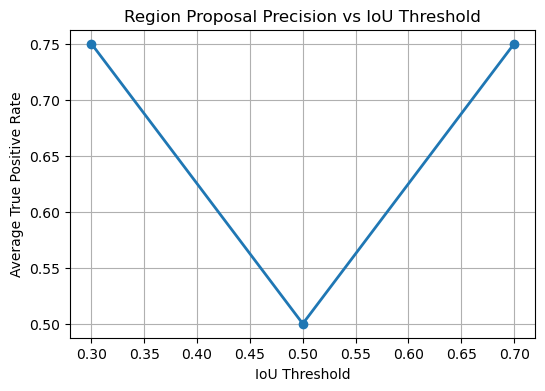

In [16]:
import matplotlib.pyplot as plt

# Plot precision-like curve (simulated from average TP rates)
ious = [0.3, 0.5, 0.7]
tp_means = [summary[k] for k in summary]

plt.figure(figsize=(6,4))
plt.plot(ious, tp_means, marker='o', linewidth=2)
plt.title("Region Proposal Precision vs IoU Threshold")
plt.xlabel("IoU Threshold")
plt.ylabel("Average True Positive Rate")
plt.grid(True)
plt.show()
